# Water Table Analysis
Author: Ian Coleman <br>
Purpose: Analyse water table data

In [33]:
import pandas as pd
import numpy as np
import scipy as sp
import subprocess
import math
import seaborn as sb
import pdb
from correlade import correlade # I wrote this --> I'm cool
from scipy import stats
import matplotlib.pyplot as plt



### Import Data

In [34]:
wt = pd.read_csv("data.csv", nrows=4000)

In [35]:
## TODO
# Strip all cols
# Drop NA
# Address unknowns and similar
# force int cols to int type etc
# break col types further into uint, int16, int8 etc
# force uints to be uints BEWARE of conversion as methods like astype can mislead
# Expand beyond dataset - any available complimentary data?
# Remove unwanted cols like cats pre encoding and recorded_by_encoded
# Graph the datetime var
# Normalisation stuff. Particularly for construction year

In [36]:
# Iterate through columns, assign them to a data type
# NB the output will need to be checked by some common sense  

cat_cols = []
int_cols = []
float_cols = []
bool_cols = []
undetermined = []

for col in wt.columns:
    clean_col = wt[col].replace(0, np.nan)
    clean_col = wt[col].replace(0.0, np.nan)
    clean_col = wt[col].dropna()
    mode_val = str(clean_col.mode().values[0]).lower()
    
    if mode_val == 'true' or mode_val == 'false':
        bool_cols.append(col)
    elif isinstance(clean_col.mode().values[0], float):
        float_cols.append(col)
    elif mode_val.isnumeric():
        int_cols.append(col)
    elif (len(clean_col.unique()) < 100):
        cat_cols.append(col)
    else:
        undetermined.append(col)
        
        
print("\n int_cols --  \n", int_cols)
print("\n float_cols --  \n", float_cols)
print("\n cat_cols --  \n", cat_cols)
print("\n bool_cols --  \n", bool_cols)
print("\n undetermined --  \n", undetermined)


 int_cols --  
 ['id', 'amount_tsh', 'gps_height', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']

 float_cols --  
 ['longitude', 'latitude']

 cat_cols --  
 ['basin', 'region', 'recorded_by', 'scheme_management', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']

 bool_cols --  
 ['public_meeting', 'permit']

 undetermined --  
 ['date_recorded', 'funder', 'installer', 'wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name']


In [37]:
# Set and check date type cols
print(wt["date_recorded"][0])
print(pd.to_datetime(wt["date_recorded"])[0])

3/14/11
2011-03-14 00:00:00


In [38]:
cat_cols = {key: "category" for key in cat_cols}
int_cols = {key: "int" for key in int_cols}
float_cols = {key: "float" for key in float_cols}
bool_cols = {key: "bool" for key in bool_cols} 
undetermined = {key: "object" for key in undetermined}
col_types = {**cat_cols, **int_cols, **float_cols, **bool_cols}

In [39]:
# # Enter the manual changes to programmatically assigned dtypes
col_types['date_recorded'] = 'datetime64'
col_types['region_code'] = 'category'
col_types['district_code'] = 'category'
# del col_types['date_recorded']

In [40]:
col_types

{'basin': 'category',
 'region': 'category',
 'recorded_by': 'category',
 'scheme_management': 'category',
 'extraction_type': 'category',
 'extraction_type_group': 'category',
 'extraction_type_class': 'category',
 'management': 'category',
 'management_group': 'category',
 'payment': 'category',
 'payment_type': 'category',
 'water_quality': 'category',
 'quality_group': 'category',
 'quantity': 'category',
 'quantity_group': 'category',
 'source': 'category',
 'source_type': 'category',
 'source_class': 'category',
 'waterpoint_type': 'category',
 'waterpoint_type_group': 'category',
 'id': 'int',
 'amount_tsh': 'int',
 'gps_height': 'int',
 'num_private': 'int',
 'region_code': 'category',
 'district_code': 'category',
 'population': 'int',
 'construction_year': 'int',
 'longitude': 'float',
 'latitude': 'float',
 'public_meeting': 'bool',
 'permit': 'bool',
 'date_recorded': 'datetime64'}

In [41]:
for col in col_types:
    wt[col] = wt[col].astype(col_types[col], errors='ignore')

In [42]:
# In this cell I sweep through possible errors using astype conversion without ignoring errors, 
# Then I patch each error and rerun until it runs through. Handy way to catch edge cases
# This won't catch everything e.g Typos -> with more type would run value_counts on all categoricals for this  
for col in float_cols:
    wt[col] = wt[col].apply(lambda x: x if isinstance(x, float) else np.nan)

for col in int_cols:
    wt[col] = wt[col].apply(lambda x: x if isinstance(x, int) else np.nan)
    wt[col] = wt[col].replace([np.inf, -np.inf], np.nan)
#     wt[col] = wt[col].replace(np.nan, 0) ->

for col in col_types:
    wt[col] = wt[col].astype(col_types[col])

In [43]:
# I visually glance through random rows for unpredicted systematic and random errors (run this cell * ~3)
wt.sample(10)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
3263,24885,30,2011-03-03,Private,9,Priva,38.762156,-7.995408,James Goloa,0,...,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
2564,46177,600,2013-02-17,Roman Cathoric-same,865,District Council,37.678755,-3.818209,Kwa Bongoito,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1837,28526,100,2011-03-18,St,737,St,36.820653,-7.366023,Kwa Cosmas,0,...,monthly,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe
3121,61743,0,2012-10-22,Government Of Tanzania,0,Government,33.347091,-3.797579,Kwa Edward John,0,...,never pay,soft,good,seasonal,seasonal,shallow well,shallow well,groundwater,other,other
872,14727,300,2013-02-26,Germany Republi,1445,CES,37.209632,-3.213078,Kwa Robert Mushi,0,...,other,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1056,48505,0,2011-07-17,Concern,0,TWESA,30.571379,-2.535302,Metusela,0,...,never pay,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe
1932,17382,0,2011-03-20,Government Of Tanzania,1177,RWE,38.428728,-5.001022,Kinyamankaa,0,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe
624,6939,0,2012-10-19,Netherlands,0,DWE,34.087778,-3.095366,Kwa Mzee Kwabi Kamata,0,...,other,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
871,72055,0,2011-04-04,Government Of Tanzania,1136,DWE,38.320080,-4.850371,Msikitini,0,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
3023,29669,500,2013-03-15,Germany Republi,757,CES,37.299641,-3.438407,Kikavu Senta,0,...,other,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [44]:
wt.dtypes

id                                int64
amount_tsh                        int64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                          category
subvillage                       object
region                         category
region_code                    category
district_code                  category
lga                              object
ward                             object
population                        int64
public_meeting                     bool
recorded_by                    category
scheme_management              category
scheme_name                      object
permit                             bool
construction_year                 int64
extraction_type                category


In [45]:
labels = pd.read_csv("labels.csv")
print('Shape: ', labels.shape)

Shape:  (59400, 2)


In [46]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [47]:
labels['id'] = labels['id'].replace(to_replace ='[!]', value = np.nan, regex = True) # aimed at specific error
labels['id'].dropna(inplace=True)
labels['id'] = labels['id'].astype(int)
labels['status_group'] = labels['status_group'].astype('category')

# Add these cols to the col type storage
cat_cols['status_group'] = 'category'

In [48]:
print("wt shape: ", wt.shape)
print("labels shape: ", labels.shape)

wt = wt.merge(labels, on='id', how='left')
print("wt shape post merge: ", wt.shape)

wt shape:  (4000, 40)
labels shape:  (59400, 2)
wt shape:  (4001, 41)


In [625]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [626]:
# encode categoricals
for col in cat_cols:
    new_name = col + '_encoded'
    wt[new_name] = wt[col].cat.codes

In [627]:
# encode booleans
for col in bool_cols:
    new_name = col + '_encoded'
    wt[new_name] = wt[col].apply(lambda x: 0 if x is False else 1)
    wt[new_name] = wt[new_name].astype(np.int8)
    
# checking it worked
# wt[['public_meeting_encoded', 'permit_encoded', 'permit', 'public_meeting']]

### Exploratory Analysis

In [628]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
0,69572,6000,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,1,1,8,7,0,1,1,0,1,0
1,8776,0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,2,2,5,4,1,1,1,0,1,1
2,34310,25,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,1,1,0,1,1,2,1,0,1,1
3,67743,0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,0,0,3,0,0,2,1,2,1,1
4,19728,0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,3,3,5,4,1,1,1,0,1,1


In [629]:
wt.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year,basin_encoded,region_encoded,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
count,4001.000000,4001.000000,4001.000000,4001.000000,4.001000e+03,4001.00000,4001.000000,4001.000000,4001.000000,4001.000000,...,4001.000000,4001.000000,4001.000000,4001.000000,4001.000000,4001.000000,4001.000000,4001.000000,4001.000000,4001.000000
mean,36915.780805,314.429643,668.396651,34.093668,-5.730290e+00,0.59985,177.259685,1302.005999,4.115221,10.043739,...,1.336166,1.336166,6.003249,4.659335,0.229943,2.169708,1.642839,0.850287,0.910772,0.702074
std,21758.525502,2183.744043,695.629987,6.688377,2.953725e+00,12.53982,410.803075,951.206581,2.447544,5.931596,...,0.813765,0.813765,2.050668,2.632711,0.429666,1.323798,0.945068,0.952801,0.285108,0.457404
min,4.000000,0.000000,-54.000000,0.000000,-1.156432e+01,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,17939.000000,0.000000,0.000000,33.100165,-8.579806e+00,0.00000,0.000000,0.000000,3.000000,5.000000,...,1.000000,1.000000,5.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,36753.000000,0.000000,361.000000,34.931556,-5.063603e+00,0.00000,25.000000,1985.000000,4.000000,10.000000,...,1.000000,1.000000,7.000000,6.000000,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000
75%,56074.000000,25.000000,1318.000000,37.292456,-3.340924e+00,0.00000,215.000000,2004.000000,6.000000,15.000000,...,2.000000,2.000000,8.000000,7.000000,0.000000,3.000000,2.000000,2.000000,1.000000,1.000000
max,74246.000000,100000.000000,2623.000000,40.345193,-2.000000e-08,698.00000,7500.000000,2013.000000,8.000000,20.000000,...,4.000000,4.000000,9.000000,7.000000,2.000000,5.000000,4.000000,3.000000,1.000000,1.000000


In [630]:
wt.dtypes

id                                        int64
amount_tsh                                int64
date_recorded                    datetime64[ns]
funder                                   object
gps_height                                int64
                                      ...      
waterpoint_type_encoded                    int8
waterpoint_type_group_encoded              int8
status_group_encoded                       int8
public_meeting_encoded                     int8
permit_encoded                             int8
Length: 64, dtype: object

In [631]:
print(wt.isna().sum())

id                                 0
amount_tsh                         0
date_recorded                      0
funder                           239
gps_height                         0
                                ... 
waterpoint_type_encoded            0
waterpoint_type_group_encoded      0
status_group_encoded               0
public_meeting_encoded             0
permit_encoded                     0
Length: 64, dtype: int64


In [632]:
# get numeric cols

# Note that I'm leaving out int8 - ensure that only categorical encoded cols are int8
numerics = wt.select_dtypes(include=['int', 'int16', 'int32', 'int64', 'float', 'float32', 
                                     'float64']).columns
numerics = list(numerics)
numerics.remove('id')

# numerics = ['gps_height', 'amount_tsh', 'status_group_encoded']\

# sanity check
numerics

In [634]:
# get categorical cols

categorics = wt.select_dtypes(include=['int8']).columns
categorics = list(categorics)

# sanity check
categorics

['basin_encoded', 'region_encoded', 'recorded_by_encoded', 'scheme_management_encoded', 'extraction_type_encoded', 'extraction_type_group_encoded', 'extraction_type_class_encoded', 'management_encoded', 'management_group_encoded', 'payment_encoded', 'payment_type_encoded', 'water_quality_encoded', 'quality_group_encoded', 'quantity_encoded', 'quantity_group_encoded', 'source_encoded', 'source_type_encoded', 'source_class_encoded', 'waterpoint_type_encoded', 'waterpoint_type_group_encoded', 'status_group_encoded', 'public_meeting_encoded', 'permit_encoded']

In [644]:
wt['construction_year'] = wt.construction_year.replace(0,np.nan)

In [645]:
#### Here I'm going to replace outliers (beyond 3 std devs)
# Replacing col mean - could delete, but would lose entire observation for the sake of one outlier
print(wt.shape)
for col in wt[numerics].columns:
    wt[col] = wt[np.abs(wt[col]-wt[col].mean()) <= (3 * wt[col].std())][col]
    mean = wt[col].mean()
    wt[col] = wt[col].fillna(mean)
print(wt.shape)

(4001, 64)
(4001, 64)


In [646]:
wt.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
0,69572,106.43117,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0.0,...,1,1,8,7,0,1,1,0,1,0
1,8776,0.00000,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0.0,...,2,2,5,4,1,1,1,0,1,1
2,34310,25.00000,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0.0,...,1,1,0,1,1,2,1,0,1,1
3,67743,0.00000,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0.0,...,0,0,3,0,0,2,1,2,1,1
4,19728,0.00000,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0.0,...,3,3,5,4,1,1,1,0,1,1


In [647]:
# print(wt.shape)
# wt.dropna(inplace=True)
# print(wt.shape)

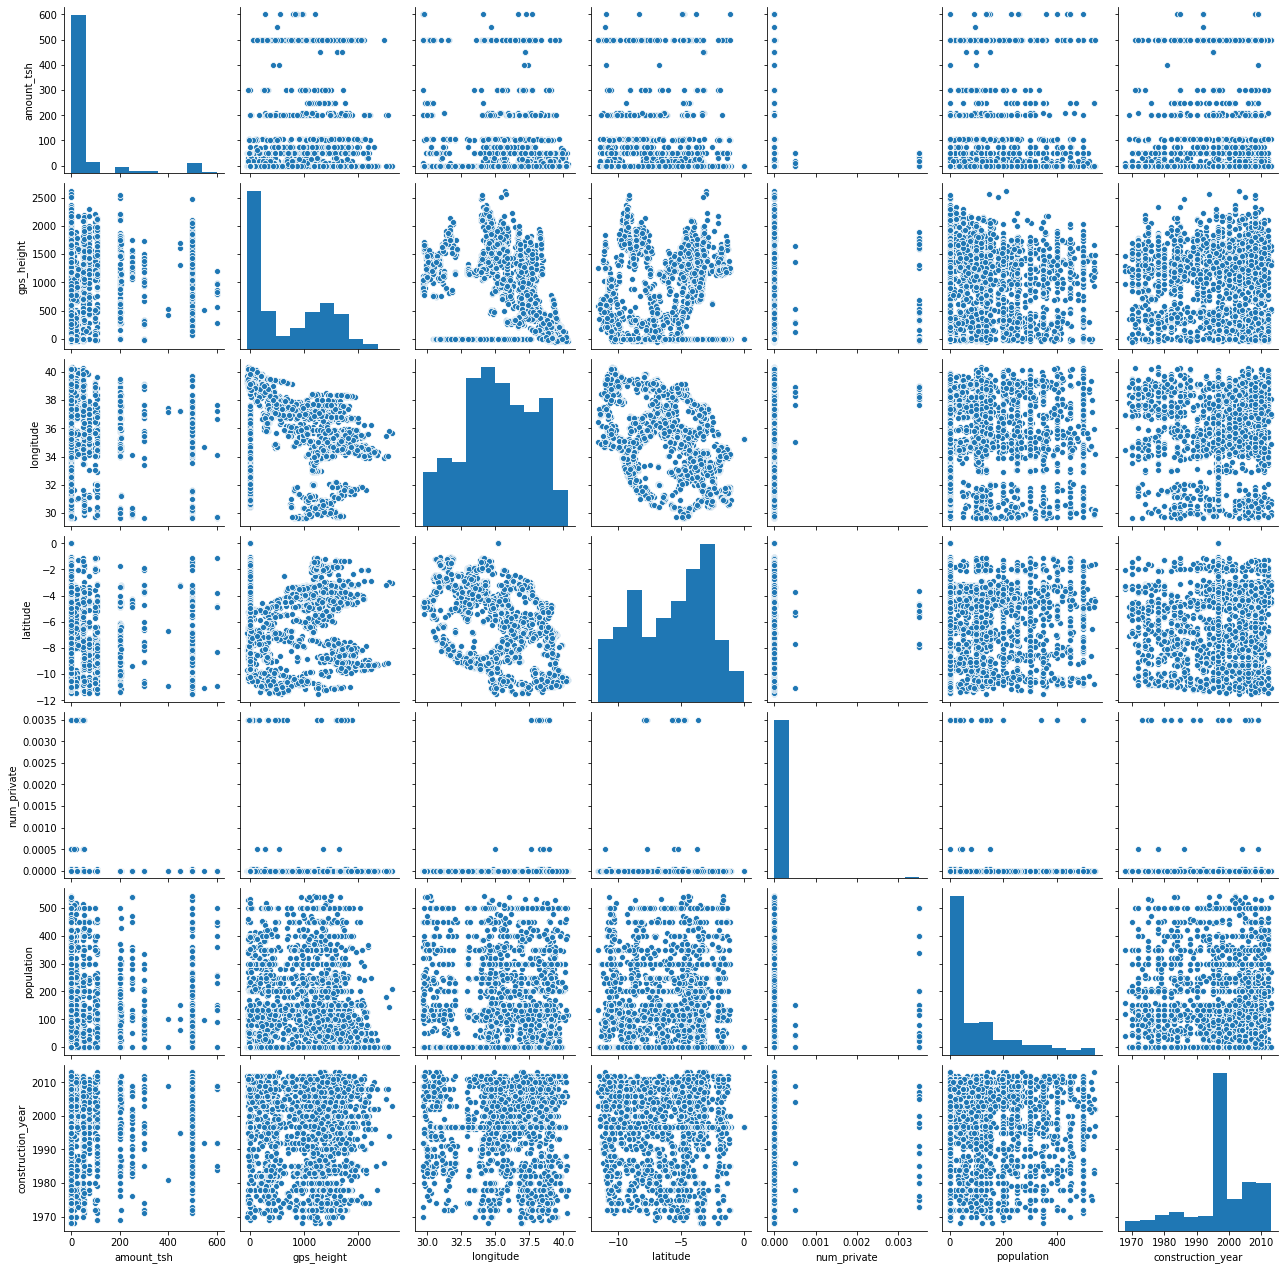

In [648]:
## Continuous vs Continuous

# Pairwise scatterplot --> visually assess for independence of features and for outliers
# More of a sanity check than anything
# This and following cells will see if numeric vars are correlated
# If so they could throw off our models, breaking the common assumption of independence
sb.pairplot(wt[numerics])

# Interpretation:
# 1. remove 0's from construction year (why didn't these get caught by cleaning std dev check? -> too many of them
# 2. gps height, lat and long seem to show some relationship
# 3. Lat, Long and Construction yr should pass as normal dist but
# 4. amount_tsh, gps_height, num_private and population look skewed 

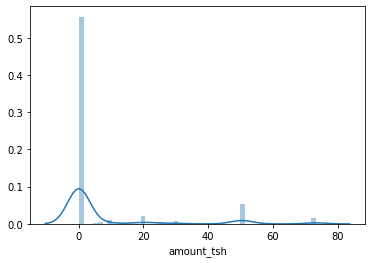

In [654]:
# Zoom in to check if it's really skewed -> maybe I should delete 0's here too 
sb.distplot(wt.amount_tsh[wt.amount_tsh.apply(lambda x: x < 100)]);

In [ ]:
# Get pairwise Distance Covariance 
# NB I made this pip library myself
# Distance correlation is more robust than pearson, ken, spear - Székely, Rizzo and Bakirov (2007) and Lyons (2013)
# less dependent on linear relationship. 0 actually does imply independence
correlade.dcorr(wt[numerics])
# Conclusions: 
# Backs up visual assessment, X3 and X9 are correlated, they correlate more strongly with y than each other
# Other feats have low correlation values

In [ ]:
sb.heatmap(wt[numerics].corr()) 
# interpretation:
# amount_tsh and gps_height might have a mild correlation
# population and gps_height also
# though remember amount and pop had skewed dist - see next cell

In [ ]:
sb.heatmap(wt[numerics].corr(method='spearman')) 
# interpretation
# 1. Correlation between pop and gps_height
# 2. 

In [ ]:
wt[numerics].corr(method='spearman')

In [658]:
## Continuous Vs Categorical

# Correlation between a continuous and a categorical --> Point biserial correlation
# Assumptions: normally distributed and homoscedastic --> Appear to be met / close enough
# This is not pretty
for col in wt[numerics].columns:
    print('\n \n -------- %s --------- \n' % str(col))
    for y in wt[categorics]:
        print('%s:' % str(y), stats.pointbiserialr(wt[col], wt[y]))
        
# Interpretation:
# Apart from num_private... almost every cont-cat pair is sig correlated?? with v weak correlation coefficent


 
 -------- amount_tsh --------- 

basin_encoded: PointbiserialrResult(correlation=0.11581935796889911, pvalue=2.0055351085765038e-13)
region_encoded: PointbiserialrResult(correlation=-0.11558966750294124, pvalue=2.2379234289282994e-13)
recorded_by_encoded: PointbiserialrResult(correlation=nan, pvalue=nan)
scheme_management_encoded: PointbiserialrResult(correlation=0.08341771944372717, pvalue=1.2637828277664876e-07)
extraction_type_encoded: PointbiserialrResult(correlation=-0.10262044923472857, pvalue=7.704862716227884e-11)
extraction_type_group_encoded: PointbiserialrResult(correlation=-0.08686883996161268, pvalue=3.72444343571429e-08)
extraction_type_class_encoded: PointbiserialrResult(correlation=-0.12129069857532296, pvalue=1.3811028717762758e-14)
management_encoded: PointbiserialrResult(correlation=0.08873527938891707, pvalue=1.8859279824354566e-08)
management_group_encoded: PointbiserialrResult(correlation=0.07857162171194956, pvalue=6.48889131221086e-07)
payment_encoded: Pointb

/home/ian/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


PointbiserialrResult(correlation=nan, pvalue=nan)
scheme_management_encoded: PointbiserialrResult(correlation=-0.012700530422526952, pvalue=0.421897379699186)
extraction_type_encoded: PointbiserialrResult(correlation=0.0006348591947898941, pvalue=0.967977927715958)
extraction_type_group_encoded: PointbiserialrResult(correlation=0.011804562751210916, pvalue=0.45538227155843053)
extraction_type_class_encoded: PointbiserialrResult(correlation=0.013549545363994074, pvalue=0.39154042868243194)
management_encoded: PointbiserialrResult(correlation=-0.02680453962912384, pvalue=0.09002712856753611)
management_group_encoded: PointbiserialrResult(correlation=-0.11536229952790117, pvalue=2.493941754830246e-13)
payment_encoded: PointbiserialrResult(correlation=0.08149045541215835, pvalue=2.4494175622692096e-07)
payment_type_encoded: PointbiserialrResult(correlation=0.07664546535364258, pvalue=1.2116885548640206e-06)
water_quality_encoded: PointbiserialrResult(correlation=-0.030189791640857704, pval

In [689]:
## Categorical vs Categorical

def cramers_V(var1,var2) :
  crosstab = np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
  stat = stats.chi2_contingency(crosstab)[0]
  obs = np.sum(crosstab) 
  mini = min(crosstab.shape)-1 
  return (stat/(obs*mini))

In [690]:
rows= []

for var1 in wt[categorics]:
  col = []
  for var2 in wt[categorics] :
    cramers = cramers_V(wt[categorics][var1], wt[categorics][var2])
    col.append(round(cramers,2)) 
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = wt[categorics].columns, index = wt[categorics].columns)

df

/home/ian/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


,basin_encoded,region_encoded,recorded_by_encoded,scheme_management_encoded,extraction_type_encoded,extraction_type_group_encoded,extraction_type_class_encoded,management_encoded,management_group_encoded,payment_encoded,...,quantity_encoded,quantity_group_encoded,source_encoded,source_type_encoded,source_class_encoded,waterpoint_type_encoded,waterpoint_type_group_encoded,status_group_encoded,public_meeting_encoded,permit_encoded
basin_encoded,1.00,0.59,NaN,0.06,0.07,0.06,0.07,0.05,0.02,0.06,...,0.02,0.02,0.07,0.06,0.02,0.05,0.05,0.01,0.01,0.03
region_encoded,0.59,1.00,NaN,0.14,0.08,0.09,0.13,0.11,0.06,0.14,...,0.05,0.05,0.11,0.12,0.06,0.10,0.09,0.02,0.05,0.16
recorded_by_encoded,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scheme_management_encoded,0.06,0.14,NaN,1.00,0.04,0.04,0.05,0.53,0.47,0.05,...,0.02,0.02,0.06,0.07,0.05,0.05,0.06,0.01,0.06,0.08
extraction_type_encoded,0.07,0.08,NaN,0.04,1.00,1.00,1.00,0.03,0.02,0.06,...,0.02,0.02,0.17,0.20,0.10,0.30,0.35,0.03,0.01,0.05
extraction_type_group_encoded,0.06,0.09,NaN,0.04,1.00,1.00,1.00,0.03,0.02,0.06,...,0.01,0.01,0.16,0.19,0.08,0.30,0.35,0.03,0.01,0.04
extraction_type_class_encoded,0.07,0.13,NaN,0.05,1.00,1.00,1.00,0.04,0.02,0.05,...,0.01,0.01,0.21,0.19,0.08,0.30,0.35,0.03,0.00,0.03
management_encoded,0.05,0.11,NaN,0.53,0.03,0.03,0.04,1.00,1.00,0.06,...,0.07,0.07,0.05,0.06,0.05,0.03,0.04,0.01,0.09,0.04
management_group_encoded,0.02,0.06,NaN,0.47,0.02,0.02,0.02,1.00,1.00,0.03,...,0.06,0.06,0.05,0.05,0.02,0.01,0.01,0.00,0.08,0.00
payment_encoded,0.06,0.14,NaN,0.05,0.06,0.06,0.05,0.06,0.03,1.00,...,0.02,0.02,0.04,0.04,0.01,0.03,0.03,0.02,0.02,0.03


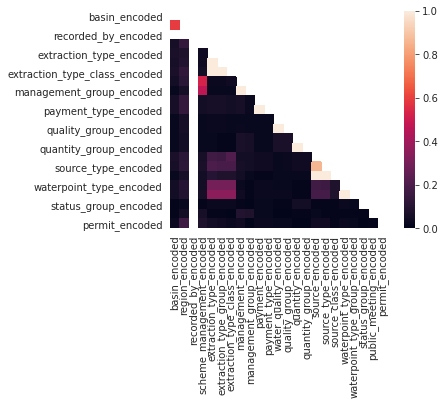

In [691]:
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sb.axes_style("white"):
  ax = sb.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

In [693]:
wt.recorded_by_encoded.value_counts() # This is suboptimal

0    4001
Name: recorded_by_encoded, dtype: int64

1. Decide which variables overlap
2. How to treat overlapped variables
3. How to compare ML models, AUC?
4. Which is best model for mixed type vars?
5. How to handle cat vars for model
6. Implement models
7. Compare